In [5]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data
import seaborn as sns

# Lorenz System, Helper Functions

In [130]:
initial_point = np.array([10.61098536,  5.87720862, 34.48052002])
params = [10, 28, 8/3]
dt = 0.001

num_samples = [100_000, 20_000, 5_000]

def dpdt(point, params=params): #position

    x,y,z = point
    sig, rho, beta = params
    
    new_x = y*dt*sig + x*(1-dt*sig)
    new_y = x*dt*(rho-z) + y*(1-dt)
    new_z = x*y*dt + z*(1-dt*beta)
    return np.array([new_x, new_y, new_z])

def make_lorenz_rollout(num_samples):
    positions = []
    positions.append(initial_point)

    # your dataset
    for _ in range(num_samples):
        positions.append(dpdt(positions[-1]))

    positions = np.stack(positions)

    labels = np.sum(np.sqrt(np.square(positions[1:num_samples+1] - positions[:num_samples])), axis=1)

    return positions, labels

In [131]:
test_samples = num_samples[0]
positions, _ = make_lorenz_rollout(test_samples)

print(positions.shape)

p_max = np.max(positions)
p_min = np.min(positions)

# Add noise
#positions = positions +np.random.randn(test_samples + 1,3) * 0.1

# Scale
positions = positions/p_max # (normalize to between 1 some negative number that won't be 1) 

(100001, 3)


In [132]:
data_x = positions[:test_samples]
data_y = positions[1:test_samples+1]
print(data_x[1], " ", data_y[0])
print(data_x.shape)

[0.23322552 0.12810979 0.760612  ]   [0.23322552 0.12810979 0.760612  ]
(100000, 3)


In [133]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [134]:
class MultiStepSeqLearner(pl.LightningModule):
    def __init__(self, model, length=3, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr
        self.length = length

    def training_step(self, batch, batch_idx):
        ''' This is with the assumption that the batches will come in of something like 
        batch = (x, y) where x and y both have shape
        shape=(batch_size, trajectory_length, input_space)'''
        x, y = batch
        rolling_inputs = x
        predictions = []
        
        for i in range(self.length):
            
            prediction = self.model.forward(rolling_inputs)[0]
                
            predictions.append(prediction)
            #print(prediction.unsqueeze(axis=1).shape)
            #print(rolling_inputs.shape)
            rolling_inputs = torch.concatenate((rolling_inputs[:, 1:self.length+1, :], prediction.unsqueeze(axis=1)), axis=1)
        

        predictions = torch.stack(predictions)
        predictions = torch.swapaxes(predictions, 0, 1)
        #print(predictions.shape, " ", y.shape)
        #trajectory = trajectory.view_as(y)
        #print(trajectory.shape)
        loss = nn.MSELoss()(predictions, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}
        
            
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [135]:
# now we have to make them into batches of sequence lengths
x = []
y = []
traj_len = 5
look_ahead = 3
for i in range(test_samples - traj_len - look_ahead):
    x.append(positions[i:i+traj_len])
    y.append(positions[i+traj_len:i+traj_len+look_ahead])

#print(x, y[0])
#print(" ")
#print(x, y[1])
data_x = np.stack(x)
data_y = np.stack(y)

In [136]:
print(data_x.shape, " ", data_y.shape)
print(data_x[0, :, :], "\n woah \n ", data_y[0, :, :], "\n ahh \n ", data_x[1, -1, :])


(99992, 5, 3)   (99992, 3, 3)
[[0.23427065 0.12975774 0.76126519]
 [0.23322552 0.12810979 0.760612  ]
 [0.23217436 0.12647715 0.75993701]
 [0.23111739 0.12486003 0.75924055]
 [0.23005482 0.12325861 0.75852296]] 
 woah 
  [[0.22898685 0.12167305 0.7577846 ]
 [0.22791372 0.12010352 0.75702579]
 [0.22683561 0.11855018 0.75624689]] 
 ahh 
  [0.22898685 0.12167305 0.7577846 ]


# NCPS

In [137]:
from ncps.wirings import NCP
out_features = 3
in_features = 3

#wiring = AutoNCP(6, out_features)  
wiring = NCP(inter_neurons=5, command_neurons=3, motor_neurons=out_features,
             sensory_fanout=5, inter_fanout=2, recurrent_command_synapses=3, motor_fanin=2)

world_model = CfC(in_features, wiring, batch_first=True, return_sequences=False, activation = "tanh", mixed_memory=True) # change to cfc, what could go wrong?

In [138]:
# Alternatively, make just an LTC
#world_model = LTC(in_features, out_features, batch_first=True, return_sequences=False)

## Test if I can save the wirings and weights

In [139]:
PATH = "models/LTC_state_dict"
torch.save(world_model.state_dict(), PATH)

adj_mat = wiring.adjacency_matrix
sens_mat = wiring.sensory_adjacency_matrix 

#wm.load_state_dict(torch.load(PATH, weights_only=True))

# Visualization and Training

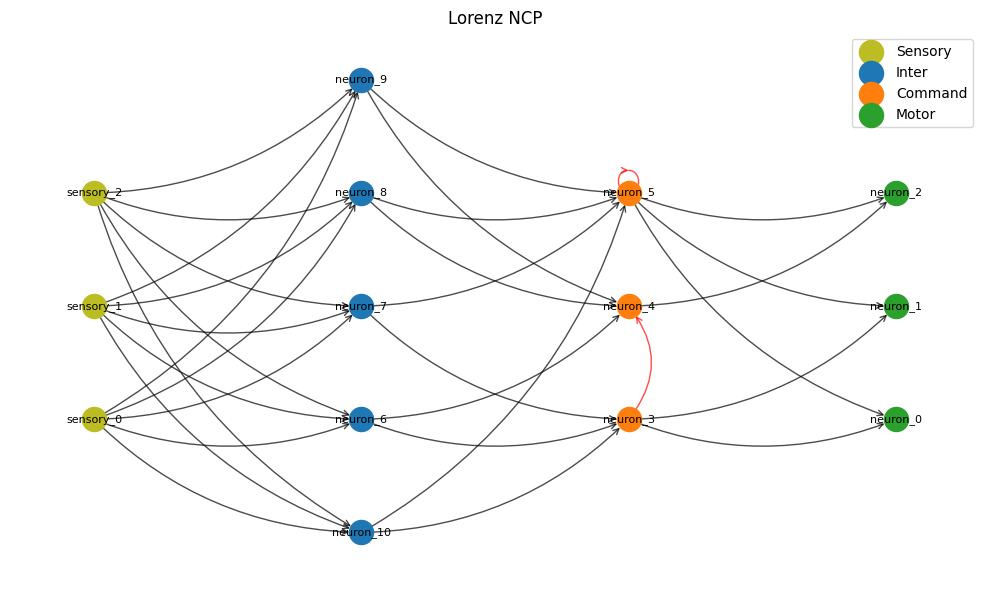

In [140]:
import matplotlib.pyplot as plt
import networkx as nx

# Obtain the graph from the wiring.
G = wiring.get_graph()

# Separate nodes by type.
sensory_nodes = [node for node, data in G.nodes(data=True) if data.get("neuron_type") == "sensory"]
inter_nodes   = [node for node, data in G.nodes(data=True) if data.get("neuron_type") == "inter"]
command_nodes = [node for node, data in G.nodes(data=True) if data.get("neuron_type") == "command"]
motor_nodes   = [node for node, data in G.nodes(data=True) if data.get("neuron_type") == "motor"]

# Assign fixed x-coordinates for a feed-forward layout:
# x = 0 for sensory, 2 for inter, 4 for command, and 6 for motor.
pos = {}
layers = [
    ("sensory", sensory_nodes),
    ("inter", inter_nodes),
    ("command", command_nodes),
    ("motor", motor_nodes)
]
x_spacing = 2.0  # horizontal spacing between layers
y_spacing = 1.0  # vertical spacing within a layer

for layer_index, (layer_name, nodes) in enumerate(layers):
    x = layer_index * x_spacing
    n = len(nodes)
    # Evenly space nodes vertically and center them if there's more than one.
    for i, node in enumerate(sorted(nodes)):
        y = (i - (n - 1) / 2) * y_spacing if n > 1 else 0
        pos[node] = (x, y)

# Separate edges into non-recurrent and recurrent (command -> command) edges.
non_recurrent_edges = []
recurrent_edges = []
for u, v, d in G.edges(data=True):
    # If both source and target are command neurons, mark as recurrent.
    if G.nodes[u]["neuron_type"] == "command" and G.nodes[v]["neuron_type"] == "command":
        recurrent_edges.append((u, v))
    else:
        non_recurrent_edges.append((u, v))


plt.figure(figsize=(10, 6))

# Draw nodes with different colors for each layer.
nx.draw_networkx_nodes(G, pos, nodelist=sensory_nodes, node_color='tab:olive', label='Sensory')
nx.draw_networkx_nodes(G, pos, nodelist=inter_nodes,   node_color='tab:blue',   label='Inter')
nx.draw_networkx_nodes(G, pos, nodelist=command_nodes, node_color='tab:orange', label='Command')
nx.draw_networkx_nodes(G, pos, nodelist=motor_nodes,   node_color='tab:green',  label='Motor')

# Draw non-recurrent edges with a gentle curve.
nx.draw_networkx_edges(
    G, pos,
    edgelist=non_recurrent_edges,
    arrows=True,
    arrowstyle='->',
    connectionstyle='arc3, rad=0.2',  # gentle curve
    alpha=0.7
)

# Draw recurrent edges with a more pronounced curve and a different color.
nx.draw_networkx_edges(
    G, pos,
    edgelist=recurrent_edges,
    arrows=True,
    arrowstyle='->',
    connectionstyle='arc3, rad=0.4',  # increased curvature
    edge_color='red',
    alpha=0.7
)

# Draw node labels.
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis('off')
plt.title("Lorenz NCP")
plt.legend()
plt.tight_layout()
plt.show()


In [141]:
learn = MultiStepSeqLearner(world_model, lr=1e-2, length = look_ahead)

trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=5,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [142]:

import torch.utils.data as data
inputs = torch.tensor(data_x, dtype=torch.float32)
outputs = torch.tensor(data_y, dtype=torch.float32).squeeze(axis=1)

print(outputs.shape)

dataloader = data.DataLoader(
    data.TensorDataset(inputs, outputs), batch_size=16, shuffle=True, num_workers=24
)

torch.Size([99992, 3, 3])


/home/tristongrayston/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [143]:
trainer.fit(learn, dataloader)

/home/tristongrayston/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | CfC  | 1.1 K  | train
---------------------------------------
1.0 K     Trainable params
82        Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=5` reached.


In [144]:
inputs.shape

torch.Size([99992, 5, 3])

In [145]:
# Save NCPS Network
num_s = str(test_samples)
PATH = f"models/NCPS_N{num_s}"
torch.save(world_model.state_dict(), PATH)

#with open(PATH + '/adj_mat.npy', 'wb') as f:
#    np.save(f, wiring.adjacency_matrix)

#with open(PATH + '/sens_mat.npy', 'wb') as f:
#    np.save(f, wiring.sensory_adjacency_matrix )



In [146]:
# NCPS Residuals
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

with torch.no_grad():
    prediction = world_model(inputs)[0].numpy()
print(prediction.shape)
# save predictions
#print("PRED: ", prediction)

set_of_predictions.append(prediction)

print(data_y.shape)

# get residuals
#x_residuals.append(prediction[:, 0] - y[:, 0])
#y_residuals.append(prediction[:, 1] - y[:, 1])
#ang_vel_residuals.append(prediction[:, 2] - y[:, 2])

#NCPS_x_res = np.stack(x_residuals).T
#NCPS_y_res = np.stack(y_residuals).T
#NCPS_ang_res = np.stack(ang_vel_residuals).T


(99992, 3)
(99992, 3, 3)


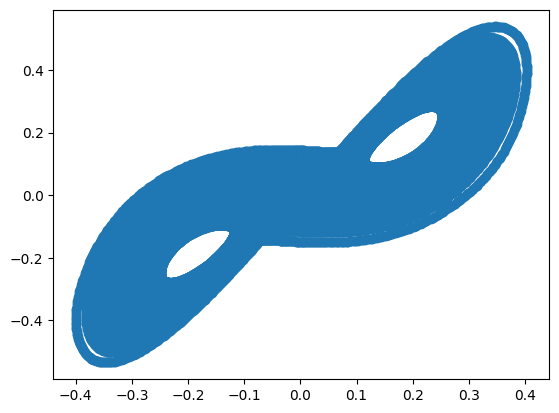

In [147]:
plt.scatter(prediction[:, 0], prediction[:, 1])
#set_of_predictions.shape

Text(0.5, 1.0, 'NCPS, trained with 5-step look ahead')

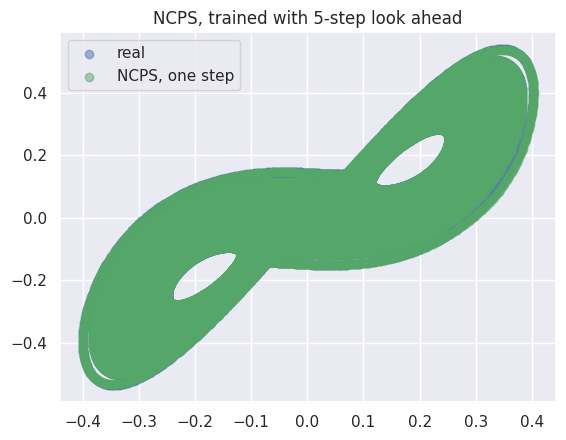

In [148]:
sns.set()
plt.scatter(positions[:, 0], positions[:, 1], alpha=0.5, label="real")
plt.scatter(prediction[:, 0], prediction[:, 1], alpha=0.5, color='g', label="NCPS, one step")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

Text(0.5, 1.0, 'NCPS, trained with 5-step look ahead')

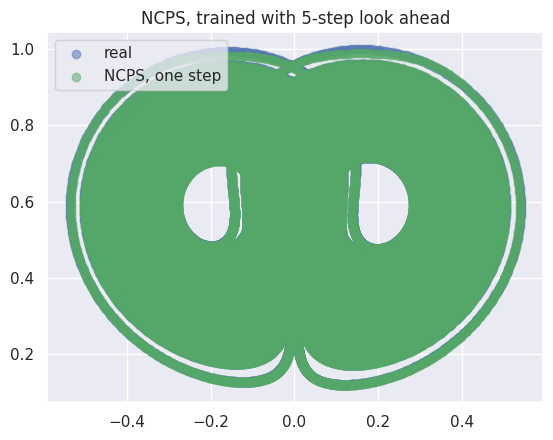

In [149]:
plt.scatter(positions[:, 1], positions[:, 2], alpha=0.5, label="real")
plt.scatter(prediction[:, 1], prediction[:, 2], alpha=0.5, color='g', label="NCPS, one step")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

For my own sanity, I should start documenting what it is that I'm doing here.

In this case, what we have is that upon recieving real inputs with time correspondance to them, we can achieve pretty solid results. Now, I want to see what that our model looks like when we try to achieve more than one step prediction.

I see two paths forward here. If we set an arbitrary time window ahead and set our model to be unable to go past that line, then we would expect worse results as opposed to not having a time window at all. The upside then is then we reduce compute time. 

How much worse results, we can test for. How much worse compute time, probably not.

In [150]:
# I'm experimenting with now we stick with a 20-step time-window. See how far into the future we can get.

rolling_inputs = inputs[0]

window = inputs.shape[1]

predictions = []

num_predictions = 1_000

for i in range(num_predictions):
    with torch.no_grad():
        prediction = world_model(rolling_inputs)[0]
        
    predictions.append(prediction)
    #prediction = torch.FloatTensor(np.expand_dims(prediction, axis=0))
    #print(rolling_inputs.shape[0])
    if rolling_inputs.shape[0] > window:
        rolling_inputs = torch.concatenate((rolling_inputs[1:window+1], prediction.unsqueeze(0)))
    else:
         rolling_inputs = torch.concatenate((rolling_inputs, prediction.unsqueeze(0)))

    #print(rolling_inputs, " ", prediction)


predictions = torch.stack(predictions)
predictions.shape


torch.Size([1000, 3])

Text(0.5, 1.0, 'NCPS, trained with 5-step look ahead')

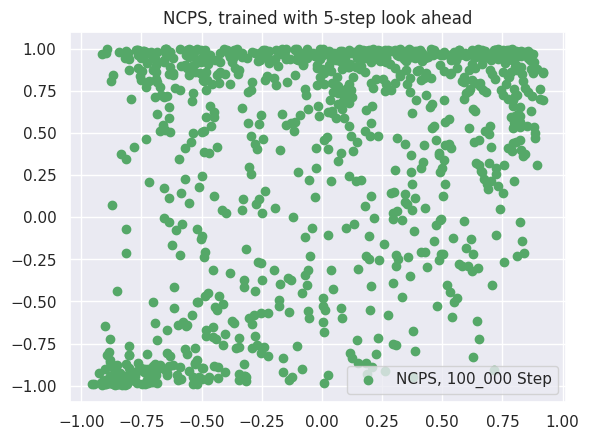

In [151]:
plt.scatter(predictions[:, 1], predictions[:, 2], color='g', label="NCPS, 100_000 Step")
#plt.scatter(y[3: 3 + num_predictions, 1], y[3: 3 + num_predictions, 2], alpha=0.5, color='b', label="real")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

Text(0.5, 1.0, 'NCPS, trained with 5-step look ahead')

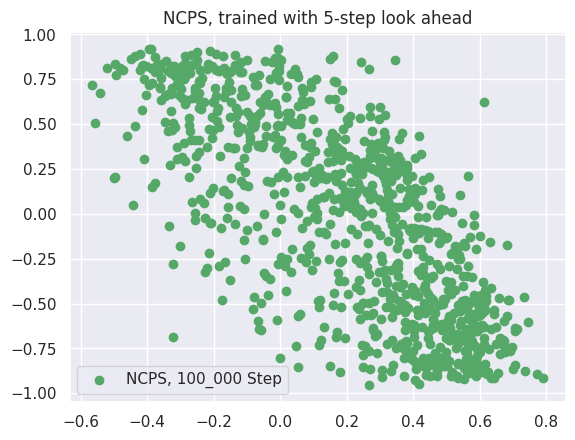

In [152]:
plt.scatter(predictions[:, 0], predictions[:, 1], color='g', label="NCPS, 100_000 Step")
#plt.scatter(y[3: 3 + num_predictions, 1], y[3: 3 + num_predictions, 2], alpha=0.5, color='b', label="real")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


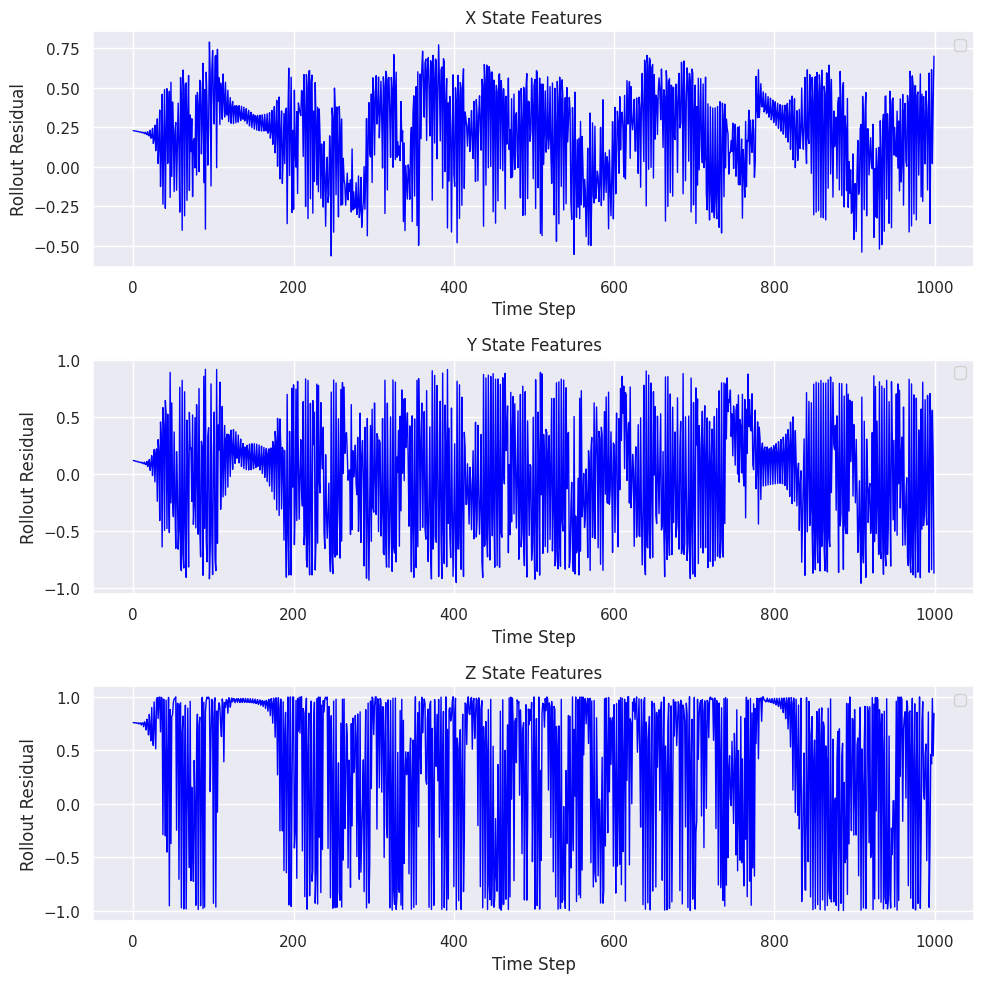

In [153]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
time_steps = np.arange(num_predictions)

# Define a function to plot the residuals on a given axis
def plot_residuals(ax, res, title):
    # Plot all individual rollouts
    #for r in range(res.shape[0]):
    ax.plot(res, color='blue', alpha=1, linewidth=1)
    
    # Compute and plot the mean
    #mean_rollout = res.mean(axis=0)
    #ax.plot(mean_rollout, color='blue', linewidth=2, label='Mean Rollout')
    
    # Compute and plot ±1 std dev
    #std_rollout = res.std(axis=0)
    #ax.fill_between(time_steps, mean_rollout - std_rollout, mean_rollout + std_rollout,
    #              color='blue', alpha=0.2, label='Mean ± 1 Std. Dev.')
    
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Rollout Residual")
    ax.set_title(title)
    ax.legend(loc='upper right')

# Plot for x_res
plot_residuals(axes[0], predictions[:, 0], "X State Features")

# Plot for y_res
plot_residuals(axes[1], predictions[:, 1], "Y State Features")

# Plot for ang_res
plot_residuals(axes[2], predictions[:, 2], "Z State Features")

plt.tight_layout()
plt.show()

## Save Model

In [154]:
num_s = str(test_samples)
PATH = f"models/CFC_state_dict_N{num_s}"
torch.save(world_model.state_dict(), PATH + '/weights')

with open(PATH + '/adj_mat.npy', 'wb') as f:
    np.save(f, wiring.adjacency_matrix)

with open(PATH + '/sens_mat.npy', 'wb') as f:
    np.save(f, wiring.sensory_adjacency_matrix )



#wm = LTC(in_features, wiring, batch_first=True, return_sequences=False)

RuntimeError: Parent directory models/CFC_state_dict_N100000 does not exist.

In [ ]:
# test saved model

out_features = 3
in_features = 3

#wiring = AutoNCP(6, out_features)  
n_wir = NCP(inter_neurons=6, command_neurons=6, motor_neurons=out_features,
             sensory_fanout=4, inter_fanout=4, recurrent_command_synapses=4, motor_fanin=3)

num_s = str(test_samples)
PATH = f"models/CFC_state_dict_N{num_s}"

with open(PATH + '/adj_mat.npy', 'rb') as f:
    adj = np.load(f)

with open(PATH + '/sens_mat.npy', 'rb') as f:
    sens = np.load(f)

n_wir.adjacency_matrix = adj
n_wir.sensory_adjacency_matrix = sens

liquid = CfC(in_features, n_wir, batch_first=True, return_sequences=False) # change to cfc, what could go wrong?
liquid.load_state_dict(torch.load(PATH+ "/weights", weights_only=True))




In [ ]:
# NCPS Residuals
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

with torch.no_grad():
    n_prediction = liquid(inputs)[0].numpy()
print(prediction.shape)
# save predictions
#print("PRED: ", prediction)

set_of_predictions.append(prediction)

print(y.shape)

# get residuals
#x_residuals.append(prediction[:, 0] - y[:, 0])
#y_residuals.append(prediction[:, 1] - y[:, 1])
#ang_vel_residuals.append(prediction[:, 2] - y[:, 2])

#NCPS_x_res = np.stack(x_residuals).T
#NCPS_y_res = np.stack(y_residuals).T
#NCPS_ang_res = np.stack(ang_vel_residuals).T


sns.set()
plt.scatter(y[:, 0], y[:, 1], alpha=0.5, label="real")
plt.scatter(n_prediction[:, 0], n_prediction[:, 1], alpha=0.5, color='g', label="NCPS, one step")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

# DNN (Residual Connection)

In [ ]:
import tensorflow as tf

def build_world_model_residual():
    xin_s = tf.keras.layers.Input((3,))

    xs = tf.keras.layers.Dense(32, activation='swish')(xin_s)
    xs = tf.keras.layers.Dense(32, activation='swish')(xs)
    xs = tf.keras.layers.Dense(3)(xs)

    xout = tf.keras.layers.Add()([xs,xin_s])
    return tf.keras.models.Model(xin_s, xout)

build_world_model_residual().summary()

In [ ]:
world_model_res = build_world_model_residual()
world_model_res.compile(loss='mse',optimizer='adam')

hist = world_model_res.fit(positions[:-1],
                           positions[1:],
                           batch_size = 64, epochs = 10, verbose=0)

plt.plot(hist.history['loss'],label='train')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.yscale('log')
plt.grid(alpha=0.5);


In [ ]:
offsets = [0, 500, 1000, 1500]
#positions[offsets]

# roll out with random actions
# evaluate by length of pendulum and disc
_state = np.array(world_model_res.predict(positions[offsets].reshape(4,3))).reshape(4,3)

pred_pos = list()
for i in range(500):
    # random action
    _state = np.array(world_model_res(_state.reshape(4,3))).squeeze()
    # pend length
    pred_pos.append(_state)

pred_pos = np.array(pred_pos)

pred_pos.shape

plt.plot(pred_pos[:,0,0],pred_pos[:,0,1],label='dnn residual prediction')
plt.plot(positions[1:501,0],positions[1:501,1],label='target position',c='tab:blue',ls='--')
plt.legend()

plt.plot(pred_pos[:,1,0],pred_pos[:,1,1],label='dnn residual prediction')
plt.plot(positions[501:1001,0],positions[501:1001,1],label='target position',c='tab:orange',ls='--')

plt.plot(pred_pos[:,2,0],pred_pos[:,2,1],label='dnn residual prediction')
plt.plot(positions[1001:1501,0],positions[1001:1501,1],label='target position',c='tab:green',ls='--')

plt.plot(pred_pos[:,3,0],pred_pos[:,3,1],label='dnn residual prediction')
plt.plot(positions[1501:2001,0],positions[1501:2001,1],label='target position',c='tab:red',ls='--')
plt.xlabel('x position')
plt.ylabel('y position')
plt.grid(alpha=0.5)
plt.title('500 steps forward')

## Save Weights

In [ ]:
# Save the weights
PATH = f"models/RESNET_state_dict_N{num_s}.weights.h5"
world_model_res.save_weights(PATH)

# Recurrent Net

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, obs_space_size, action_space_size, hidden_size):
        super().__init__()
        self.l0 = nn.Sequential(
            nn.Linear(obs_space_size + action_space_size, 32),
            nn.ReLU()
        )
        
        self.rnn = nn.RNN(32, hidden_size, batch_first=True)

        self.l1 = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, obs_space_size),
        )
        self.hidden_size = hidden_size

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(1, x.size(0), self.hidden_size)

        out = self.l0(x)
        out, ht = self.rnn(out, h0)
        out = self.l1(out)
        out = out[:, -1, :]
        return out, ht

In [ ]:
# Instantiate your model
# Adjust obs_space_size, action_space_size, hidden_size to match your setup

# now we have to make them into batches of sequence lengths
x = []
y = []
traj_len = 5
look_ahead = 1
for i in range(test_samples - traj_len - look_ahead):
    x.append(positions[i:i+traj_len])
    y.append(positions[i+traj_len:i+traj_len+look_ahead])

#print(x, y[0])
#print(" ")
#print(x, y[1])
data_x = np.stack(x)
data_y = np.stack(y)

inputs = torch.tensor(data_x, dtype=torch.float32)
outputs = torch.tensor(data_y, dtype=torch.float32).squeeze(axis=1)

print(outputs.shape)

dataloader = data.DataLoader(
    data.TensorDataset(inputs, outputs), batch_size=16, shuffle=True, num_workers=24
)

obs_space_size = 3
action_space_size = 0
hidden_size = 16
model = SimpleRNN(obs_space_size, action_space_size, hidden_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 20
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_X, batch_Y in dataloader:

        #print(batch_X.shape, " ", batch_Y.shape)
        
        # Reshape inputs/targets to (batch_size, seq_len, features).
        # Here we treat each sample as a sequence of length 1.
        # If you have a longer sequence, reshape accordingly.
        batch_X = batch_X # shape -> [batch_size, 1, input_dim]
        batch_Y = batch_Y  # shape -> [batch_size, 1, obs_space_size]

        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = model(batch_X)

        #print(outputs.shape)
        
        # Compute loss
        loss = criterion(outputs, batch_Y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Print the average loss over this epoch
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.5f}")

In [ ]:
# NCPS Residuals
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

with torch.no_grad():
    prediction = model(inputs)[0].numpy()
print(prediction.shape)
# save predictions
#print("PRED: ", prediction)

set_of_predictions.append(prediction)

#print(y.shape)

# get residuals
#x_residuals.append(prediction[:, 0] - y[:, 0])
#y_residuals.append(prediction[:, 1] - y[:, 1])
#ang_vel_residuals.append(prediction[:, 2] - y[:, 2])

#NCPS_x_res = np.stack(x_residuals).T
#NCPS_y_res = np.stack(y_residuals).T
#NCPS_ang_res = np.stack(ang_vel_residuals).T


In [ ]:
sns.set()
plt.scatter(positions[:, 0], positions[:, 1], alpha=0.5, label="real")
plt.scatter(prediction[:, 0], prediction[:, 1], alpha=0.5, color='g', label="NCPS, one step")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")

## Save weights

In [58]:
num_s = str(test_samples)
PATH = f"models/RNN_state_dict_N{num_s}"
torch.save(model.state_dict(), PATH)

# Neural ODES

In [100]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class NeuralODE(nn.Module):
    '''
    Neural ODE's are still neural networks. torchhe challenge is to find out where they differ.
    '''
    def __init__(self, input_dims, output_dims):
        super(NeuralODE, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


        self.net = nn.Sequential(
            nn.Linear(self.input_dims, 64),
            #nn.torchanh(),
            nn.Linear(64, 64),
            #nn.Tanh(),
            nn.Linear(64, self.output_dims)
        ).to(device)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)


    def forward(self, t, x):
        return self.net(x)

In [101]:
data = torch.FloatTensor(positions).to(device)
data.shape

torch.Size([5001, 3])

In [102]:
from math import pi
from torchdiffeq import odeint, odeint_adjoint
from tqdm import tqdm
epochs = 2
fx = NeuralODE(3, 3).to(device)

t_axis = torch.FloatTensor(np.arange(0, test_samples, 1))

In [103]:
fx.forward(1, data[0])

tensor([ 0.1762, -0.2547, -0.1606], device='cuda:0', grad_fn=<ViewBackward0>)

In [105]:
# Suppose data_x is a NumPy array or list. Convert it once outside the loop:
#data_x_torch = torch.tensor(data_x, dtype=torch.float).to(device)
foresight_int = 2
# Likewise, ensure your time axis is also a PyTorch tensor:
for i in tqdm(range(len(data) - (foresight_int + 1))):
    fx.net.zero_grad()

    # Now pass torch tensors to odeint.
    y0 = data_x_torch[i]  # This is a single time step; still a torch tensor
    t_slice = t_axis_torch[i : i + foresight_int]  # Also a torch tensor

    #print(fx.forward(1, data[i]))
    
    output = odeint(fx, data[i], t_slice)
    #print(output)
    #print(output.requires_grad)

    # Since 'data' in your snippet might also be NumPy, 
    # make sure it's a torch tensor for the loss:

    # Now compute the loss
    loss = torch.mean((data_torch[i : i + foresight_int] - output)**2)
    loss.backward()


100%|███████████████████████████████████████████████████████████████████████████████| 4998/4998 [03:58<00:00, 20.92it/s]


In [125]:
predictions = []

num_predictions = 1_000

input_data = data

for i in range(num_predictions):
    #print(t_axis_torch[i : i + foresight_int].shape, "\n", input_data[i].shape)
    with torch.no_grad():
        prediction = fx(t_axis_torch[i : i + foresight_int], input_data[i])
        
    predictions.append(prediction)
    #prediction = torch.FloatTensor(np.expand_dims(prediction, axis=0))
    #print(rolling_inputs.shape[0])
    
    #print(rolling_inputs, " ", prediction)


predictions = torch.stack(predictions).cpu()
predictions.shape

torch.Size([1000, 3])

In [ ]:
# NCPS Residuals
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

with torch.no_grad():
    prediction = world_model(inputs)[0].numpy()
print(prediction.shape)
# save predictions
#print("PRED: ", prediction)

set_of_predictions.append(prediction)

print(data_y.shape)

Text(0.5, 1.0, 'NCPS, trained with 5-step look ahead')

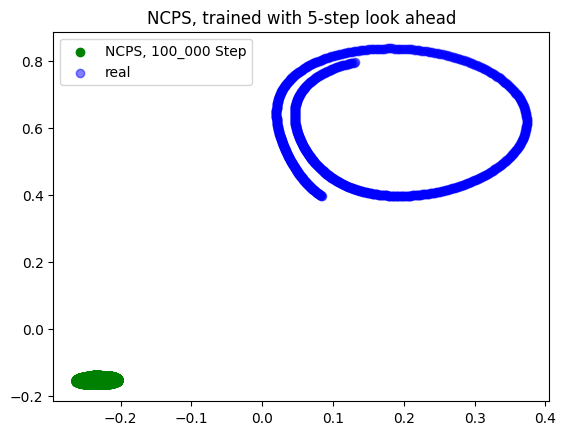

In [129]:
plt.scatter(predictions[:, 1], predictions[:, 2], color='g', label="NCPS, 100_000 Step")
plt.scatter(positions[3: 3 + num_predictions, 1], positions[3: 3 + num_predictions, 2], alpha=0.5, color='b', label="real")
plt.legend()
plt.title("NCPS, trained with 5-step look ahead")